# Imports

In [33]:
import astropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Plot cosmetics

In [34]:
suptitle_size = 24
title_size = 20
axislabel_size = 18
axistick_size = 16

gray_color = (0.2, 0.2, 0.2)

# File operations

- J1311 period: 93.8 minutes = .065 days -> freq = 15.4

In [35]:
directory = './data/J1311_5min/'
pulsar_name = 'J1311'

# > 2 GeV photons only
twogev_file_name = 'new_J1311_lc_2GeV.txt'
twogev_file_path = directory + twogev_file_name

# All photons
full_file_name = 'new_J1311_lc.txt'
full_file_path = directory + full_file_name

### Convert all delimiters to tab (only do this once/if necessary)

##### J1311_lc
- no header
- comma delim
- " quotations

# Open data from files

### Create pandas dataframe to contain all of the data

In [4]:
twogev_df = pd.read_csv(twogev_file_path, sep = '\t', header = 0)
full_df = pd.read_csv(full_file_path, sep = ',', header = None, names = ['TIME', 'TIME DEL', 'COUNTS', 'ERROR',\
                     'EXPOSURE', 'RATE', 'RATE_ERROR'])

In [5]:
twogev_df.head()

,TIME,TIMEDEL,COUNTS,ERROR,EXPOSURE,RATE,RATE_ERROR
0,239557567.0,300.0,0,1.866025,0.0,NaN,NaN
1,239557867.0,300.0,0,1.866025,0.0,NaN,NaN
2,239558167.0,300.0,0,1.866025,0.0,NaN,NaN
3,239558467.0,300.0,0,1.866025,0.0,NaN,NaN
4,239558767.0,300.0,0,1.866025,0.0,NaN,NaN


In [6]:
full_df.head()

,TIME,TIME DEL,COUNTS,ERROR,EXPOSURE,RATE,RATE_ERROR
0,239557567.0,300.0,0,1.866025,0.0,NaN,NaN
1,239557867.0,300.0,0,1.866025,0.0,NaN,NaN
2,239558167.0,300.0,0,1.866025,0.0,NaN,NaN
3,239558467.0,300.0,0,1.866025,0.0,NaN,NaN
4,239558767.0,300.0,0,1.866025,0.0,NaN,NaN


### Put the 'TIME' and 'RATE' columns into a numpy array
##### The arg twogev_df['EXPOSURE'] != 0 means we slice out only the data where measurements were taken

In [7]:
twogev_data = twogev_df[(twogev_df['EXPOSURE'] != 0) & (twogev_df['RATE'] < 0.000005)][['TIME', 'RATE']].values
full_data = full_df[(full_df['EXPOSURE'] != 0) & (full_df['RATE'] < 0.000010)][['TIME', 'RATE']].values

##### Convert seconds to days (because we expect to find periodicity in days), offset to $t_{0} = 0$, normalize rate

In [8]:
for data in [twogev_data, full_data]:
    data[:,0] = (data[:,0] - full_data[0,0])/(24*60*60.0)

# Plot the rate time-series

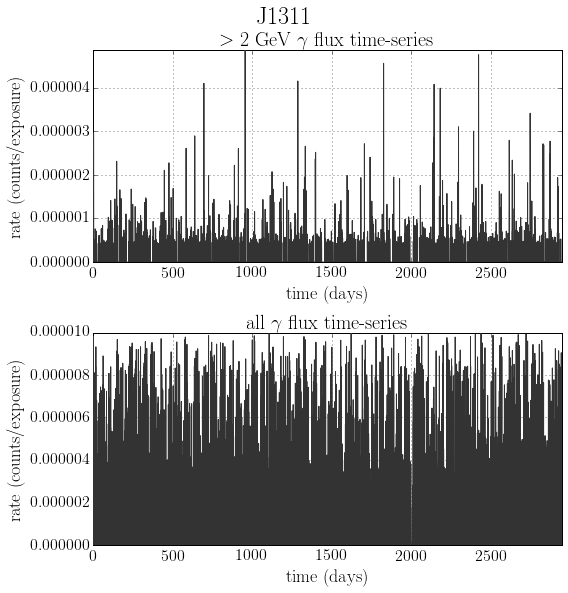

In [13]:
# Fig initialization
fig = plt.figure(figsize = (8,8))
ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

plt.suptitle(pulsar_name, size = suptitle_size,  y = 1.025)

# > 2 GeV plot
plt.sca(ax0)
plt.plot(twogev_data[:,0], twogev_data[:,1], zorder = 100, c = gray_color) # zorder set large so data appears over grid

plt.xlim(np.min(twogev_data[:,0]), np.max(twogev_data[:,0]))
plt.ylim(0, np.max(twogev_data[:,1]))

plt.grid()
plt.tick_params(labelsize = axistick_size)

plt.title(r'$>2$ GeV $\gamma$ flux time-series', size = title_size)
plt.xlabel('time (days)', size = axislabel_size)
plt.ylabel('rate (counts/exposure)', size = axislabel_size)

# All photons plot
plt.sca(ax1)
plt.plot(full_data[:,0], full_data[:,1], zorder = 100, c = gray_color)

plt.xlim(np.min(full_data[:,0]), np.max(full_data[:,0]))
plt.ylim(0,np.max(twogev_data[:,1]))

plt.grid()
plt.tick_params(labelsize = axistick_size)

plt.title(r'all $\gamma$ flux time-series', size = title_size)
plt.xlabel('time (days)', size = axislabel_size)
plt.ylabel('rate (counts/exposure)', size = axislabel_size)

# Finalize, save, display plot

fig.tight_layout()

#plt.xlim(0,10)
plt.ylim(0,np.max(full_data[:,1]))
#plt.savefig('./' + pulsar_name + '_time-series.png', dpi = 300)

plt.show()

# Folding

0.325694444444


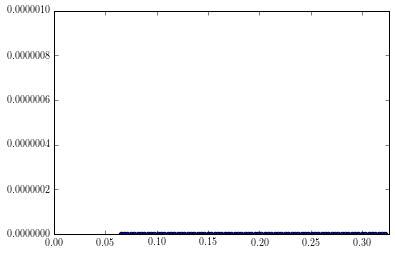

In [32]:
a = 0
b = 100000

interval = (5*93.8/(60.*24))
print interval

data_subset = full_data[a:b, :]
for i in range(data_subset.shape[0]):
    data_subset[i,0] = 1.*data_subset[i,0]%interval

    
bin_width = interval/100.0
num_bins = 100
bins = [i*bin_width for i in range(num_bins)]

time = bins
signal = [0 for i in range(num_bins)]

calculated_bins = np.digitize(data_subset[:,0], bins)

for j, num in enumerate(calculated_bins):
    signal[num-1] += data_subset[j,1]
    #plt.plot(twogev_power)
    #plt.show()
    
    
    
    
plt.scatter(time, signal)

plt.xlim(0, interval)
plt.ylim(0,0.000001)
#plt.ylim(0, np.max(data_subset[:,1]))
plt.show()

# Power spectral density (Lomb-Scargle periodogram)

- [PSD](https://en.wikipedia.org/wiki/Spectral_density) is the Fourier transform of the time-series, squared:
$$ S\left(f\right)=\|\hat{x}\left(f\right)\|^{2} = \left[\int_{-\infty}^{\infty}e^{-2\pi i f t}x\left(t\right)dt\right]^{2}$$
- This is useful because it tells us how much of the total energy $~x^{2}$ is due to signal components at a given frequency, which may represent some underlying physical process
- E.g., for ms-pulsars the PSD will have a strong peak at their rotational spin period ~1000 Hz $\left(1/10^{-3} s\right)$
- For discretely sampled data, we approximate the PSD with something called a **periodogram**
- If the data is *evenly sampled*, we simply replace the Fourier transform with a discrete Fourier transform
- People still usually refer to this as the 'PSD', but it is actually just an estimate
- The periodogram is noisy so you can use some tricks to clean up the signal, e.g., Welch's method
- Finally, the formula for the periodogram can be adapted for data that is not evenly sampled using something called the Lomb-Scargle periodogram
- There is a fast Lomb-Scargle implementation in the Python astropy package written by Jake VanderPlas that we can use

In [99]:
from astropy.stats import LombScargle

##### Calculate Lomb-Scargle for multiple segments

In [100]:
print twogev_data.shape[0]

254240


##### LS a single interval

/home/preston/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


254240.0
2946.53472222


/home/preston/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


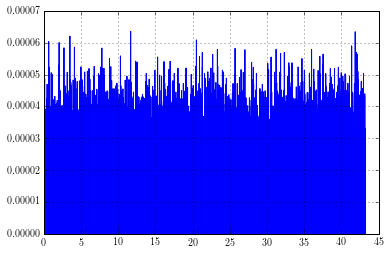

In [117]:
num_intervals = 1.
twogev_sample_length = twogev_data.shape[0]/num_intervals
full_sample_length = full_data.shape[0]/num_intervals

twogev_frequency_list = []
twogev_power_list = []


seg_start = 0
seg_stop = twogev_sample_length

twogev_frequency, twogev_power = astropy.stats.LombScargle(twogev_data[seg_start:seg_stop, 0],\
                                                       twogev_data[seg_start:seg_stop, 1]).autopower(nyquist_factor = 1)

print seg_stop
print twogev_data[seg_stop-1, 0]

plt.plot(twogev_frequency, twogev_power)
plt.grid()

plt.show()

In [102]:
num_intervals = 3.
twogev_sample_length = twogev_data.shape[0]/num_intervals
full_sample_length = full_data.shape[0]/num_intervals

twogev_frequency_list = []
twogev_power_list = []

for i in range(int(num_intervals - 1)):

    seg_start = twogev_sample_length*i
    seg_stop = twogev_sample_length*(i+1)
    
    twogev_frequency, twogev_power = astropy.stats.LombScargle(twogev_data[seg_start:seg_stop, 0],\
                                                           twogev_data[seg_start:seg_stop, 1]).autopower()
    
    twogev_frequency_list.append(twogev_frequency)
    twogev_power_list.append(twogev_power)

/home/preston/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


##### Digitize the data

In [103]:
bin_width = 5
num_bins = int(np.max(twogev_frequency)/bin_width)
bins = [i*bin_width for i in range(num_bins)]

twogev_power = []

In [104]:
twogev_frequency = bins
twogev_power = [0 for i in range(num_bins)]
for i in range(len(twogev_frequency_list)):
    calculated_bins = np.digitize(twogev_frequency_list[i], bins)
    for j, num in enumerate(calculated_bins):
        twogev_power[num-1] += twogev_power_list[i][j]
    #plt.plot(twogev_power)
    #plt.show()

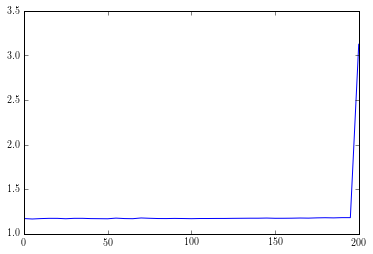

In [105]:
plt.plot(bins, twogev_power)
#plt.ylim(1,1.3)
plt.show()

##### Plot the results

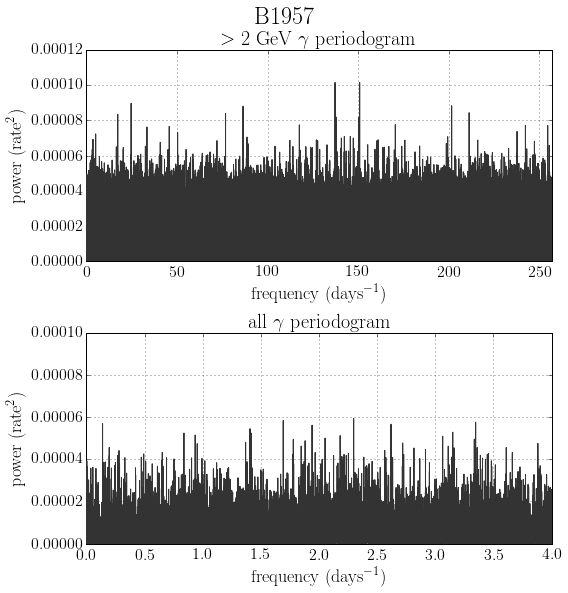

In [33]:
# Fig initialization
fig = plt.figure(figsize = (8,8))
ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

f0 = np.min(full_ls_data[:,0])
f1 = np.max(full_ls_data[:,0])

plt.suptitle(pulsar_name, size = suptitle_size,  y = 1.025)

# > 2 GeV plot
plt.sca(ax0)
plt.plot(twogev_ls_data[:,0], twogev_ls_data[:,1], zorder = 100, c = gray_color) # zorder set large so data appears over grid

plt.xlim(f0, f1)

plt.grid()
plt.tick_params(labelsize = axistick_size)

plt.title(r'$>2$ GeV $\gamma$ periodogram', size = title_size)
plt.xlabel('frequency (days$^{-1}$)', size = axislabel_size)
plt.ylabel('power (rate$^{2}$)', size = axislabel_size)

# All photons plot
plt.sca(ax1)
plt.plot(full_ls_data[:,0], full_ls_data[:,1], zorder = 100, c = gray_color)

#plt.xlim(f0, f1)
plt.xlim(0,4)

plt.grid()
plt.tick_params(labelsize = axistick_size)

plt.title(r'all $\gamma$ periodogram', size = title_size)
plt.xlabel('frequency (days$^{-1}$)', size = axislabel_size)
plt.ylabel('power (rate$^{2}$)', size = axislabel_size)

# Finalize, save, display plot

fig.tight_layout()

#plt.savefig('./' + pulsar_name + '_time-series.png', dpi = 300)

plt.show()

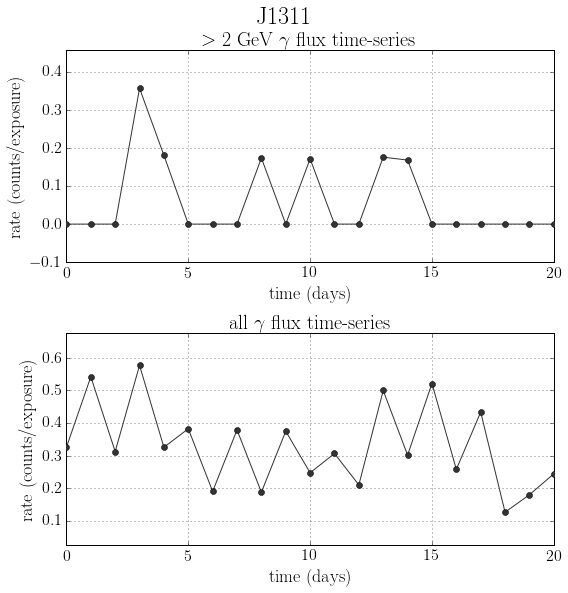

In [45]:
# Fig initialization
fig = plt.figure(figsize = (8,8))
ax0 = fig.add_subplot(2,1,1)
ax1 = fig.add_subplot(2,1,2)

plt.suptitle(pulsar_name, size = suptitle_size,  y = 1.025)

ti = 0
tf = 20

# > 2 GeV plot
plt.sca(ax0)
plt.plot(twogev_data[:,0], twogev_data[:,1], '-o', zorder = 100, c = gray_color) # zorder set large so data appears over grid

plt.xlim(ti, tf)
plt.ylim(np.min(twogev_data[ti:tf,1]) - 0.1, np.max(twogev_data[ti:tf,1]) + 0.1)

plt.grid()
plt.tick_params(labelsize = axistick_size)

plt.title(r'$>2$ GeV $\gamma$ flux time-series', size = title_size)
plt.xlabel('time (days)', size = axislabel_size)
plt.ylabel('rate (counts/exposure)', size = axislabel_size)

# All photons plot
plt.sca(ax1)
plt.plot(full_data[:,0], full_data[:,1], '-o', zorder = 100, c = gray_color)

plt.xlim(ti,tf)
plt.ylim(np.min(full_data[ti:tf,1])-.1, np.max(full_data[ti:tf,1])+.1)

plt.grid()
plt.tick_params(labelsize = axistick_size)

plt.title(r'all $\gamma$ flux time-series', size = title_size)
plt.xlabel('time (days)', size = axislabel_size)
plt.ylabel('rate (counts/exposure)', size = axislabel_size)

# Finalize, save, display plot

fig.tight_layout()

#plt.savefig('./' + pulsar_name + '_time-series.png', dpi = 300)

plt.show()

In [38]:
360-69

291

In [39]:
360-53

307

In [42]:
360-12

348